# 0416 - 實作LSTM

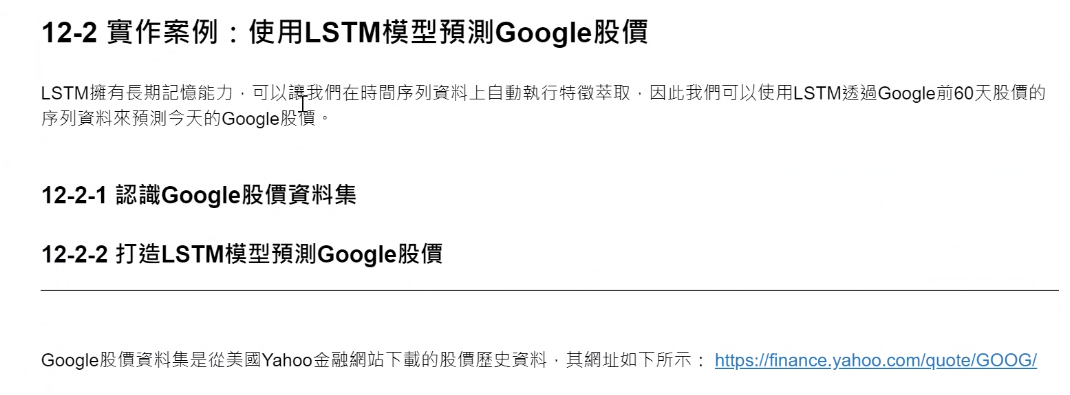
https://finance.yahoo.com/quote/GOOG/?guccounter=1
進入"Historical Data"，並選取日期
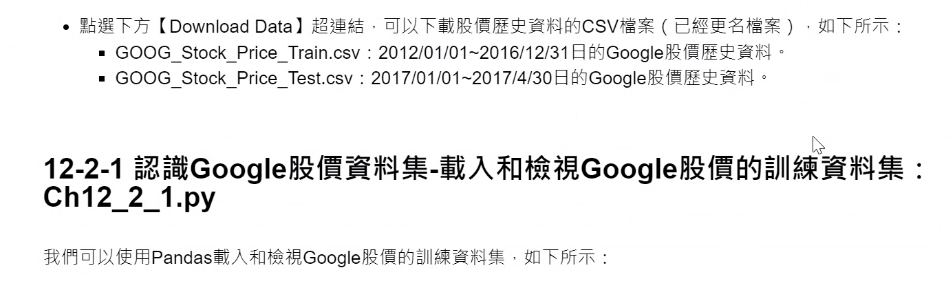

In [63]:
import pandas as pd
df_train = pd.read_csv("./GOOG/GOOG_Stock_Price_Train.csv",header=0,
                      index_col="Date",parse_dates=True)  # 宣告欄位"Date"為索引，且為日期資料
print(df_train.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03  325.250885  332.827484  324.966949  331.462585  331.462585   
2012-01-04  331.273315  333.873566  329.076538  332.892242  332.892242   
2012-01-05  329.828735  330.745270  326.889740  328.274536  328.274536   
2012-01-06  328.344299  328.767700  323.681763  323.796326  323.796326   
2012-01-09  322.042908  322.291962  309.455078  310.067780  310.067780   

              Volume  
Date                  
2012-01-03   7380561  
2012-01-04   5749470  
2012-01-05   6590410  
2012-01-06   5405987  
2012-01-09  11688849  


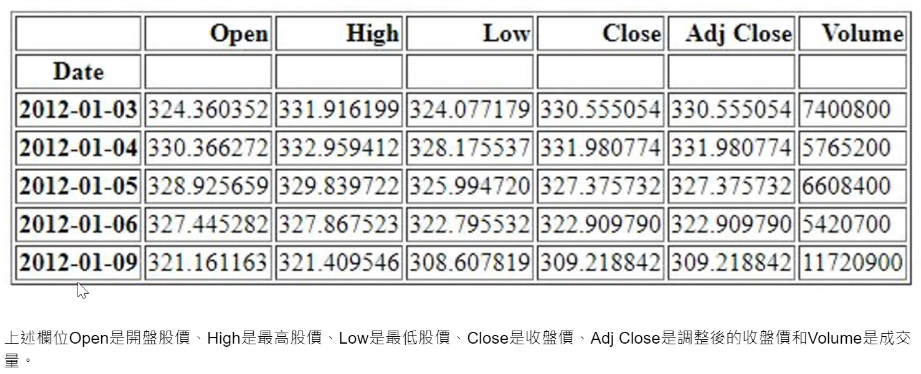
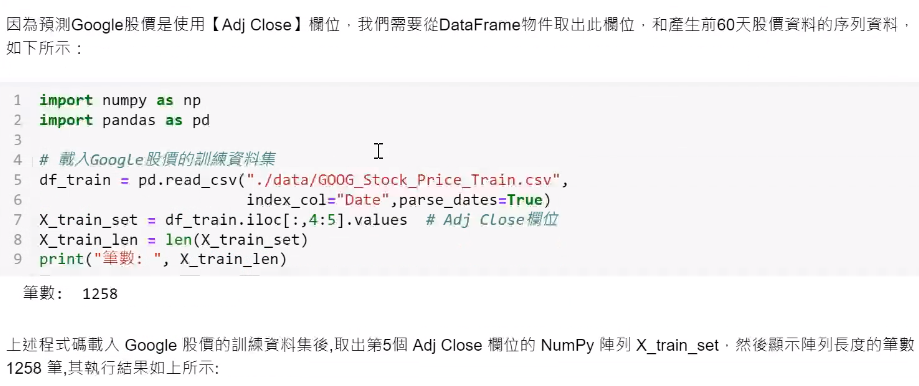

### 資料前處理

In [64]:
import numpy as np
import pandas as pd

# 載入股價資料訓練集
df_train = pd.read_csv("./GOOG/GOOG_Stock_Price_Train.csv",header=0,
                      index_col="Date",parse_dates=True)  
X_train_set = df_train.iloc[:,4:5].values  # Adj Close 欄位
print(X_train_set[:5])
X_train_len = len(X_train_set)
print(X_train_len)

[[331.462585]
 [332.892242]
 [328.274536]
 [323.796326]
 [310.06778 ]]
1258


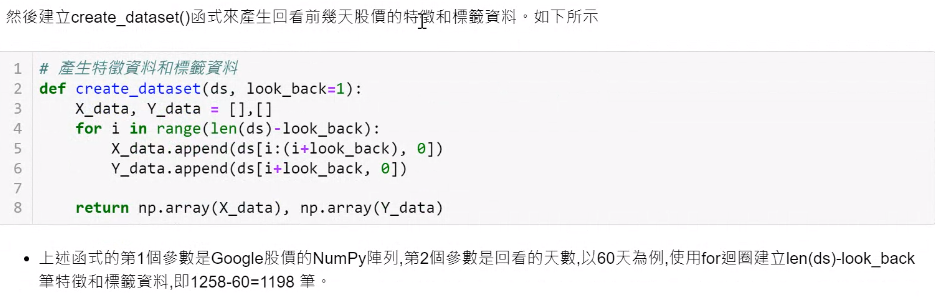

In [65]:
# 檢查資料集
print(X_train_set[:10])

[[331.462585]
 [332.892242]
 [328.274536]
 [323.796326]
 [310.06778 ]
 [310.406525]
 [311.811249]
 [313.644379]
 [311.328064]
 [313.116364]]


In [66]:
def create_dataset(ds, look_back=1):
    X_data, Y_data = [], []  # X: Adj Close for look back; Y: Adj Close label
    for i in range(len(ds)-look_back):  # 設定可以回看的資料範圍(資料集長度-回看的天數)
        X_data.append(ds[i:(i+look_back), 0])
        Y_data.append(ds[i+look_back, 0])
        
    return np.array(X_data), np.array(Y_data)

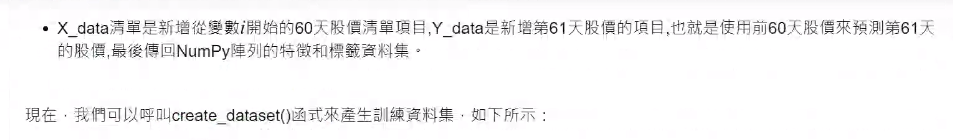

In [67]:
# 由函數回傳值產生訓練集
look_back = 60
X_train, Y_train = create_dataset(X_train_set, look_back=look_back)
print("回看天數：",look_back)
print(X_train.shape)
print(Y_train.shape)

回看天數： 60
(1198, 60)
(1198,)


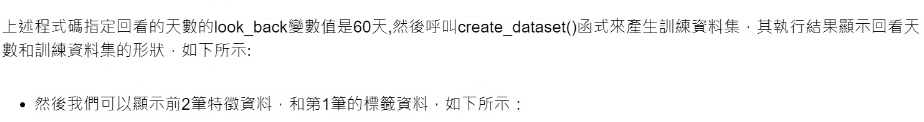

In [70]:
print(X_train[0])
# print(X_train_set[:60]) # 第一筆資料取第一筆答案的前60天的數據

[331.462585 332.892242 328.274536 323.796326 310.06778  310.406525
 311.811249 313.644379 311.328064 313.116364 315.273285 318.590851
 291.900879 291.666748 289.380341 283.681702 282.989288 288.907104
 287.766388 288.971863 289.330505 291.462524 297.051575 303.407745
 302.252075 303.786346 304.588318 301.8237   304.95694  303.741516
 301.649353 302.127563 301.191071 305.853577 302.8349   301.923309
 303.811249 303.517334 308.040375 307.970642 310.037903 309.465057
 305.978119 301.350464 302.267029 302.436401 299.004272 301.445099
 307.736542 306.844879 309.405273 311.352966 315.806274 315.562195
 318.795074 321.818756 320.095215 323.452606 322.301941 326.655609]


In [71]:
print(Y_train[0])  
# print(X_train_set[60]) # 第一筆答案

322.994324


組合程式碼，建立訓練資料集

In [72]:
import numpy as np
import pandas as pd

# 載入股價資料訓練集
df_train = pd.read_csv("./GOOG/GOOG_Stock_Price_Train.csv",header=0,
                      index_col="Date",parse_dates=True)  
X_train_set = df_train.iloc[:,4:5].values  # Adj Close 欄位
# print(X_train_set[:10])
X_train_len = len(X_train_set)
print(X_train_len)
look_back = 60
X_train, Y_train = create_dataset(X_train_set, look_back=look_back)
print("回看天數：",look_back)
print(X_train.shape)
print(Y_train.shape)
# print(X_train[0])
# print(Y_train[0])  

1258
回看天數： 60
(1198, 60)
(1198,)


## 以LSTM建立預測模型

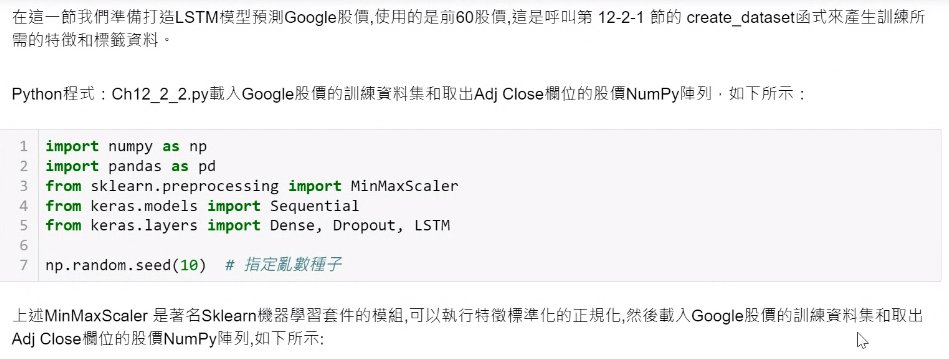

In [73]:
# 引用正規化套件，將特徵標準化
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

np.random.seed(10)

In [74]:
# 載入股價資料訓練集
df_train = pd.read_csv("./GOOG/GOOG_Stock_Price_Train.csv",header=0,
                      index_col="Date",parse_dates=True)  
X_train_set = df_train.iloc[:,4:5].values  # Adj Close 欄位
X_train_len = len(X_train_set)
print("筆數：", X_train_len)
print(X_train_set[:5])
print(X_train_set[-5:])

筆數： 1258
[[331.462585]
 [332.892242]
 [328.274536]
 [323.796326]
 [310.06778 ]]
[[789.909973]
 [791.549988]
 [785.049988]
 [782.789978]
 [771.820007]]


In [75]:
# 正規化訓練資料 (特徵標準化步驟)
sc = MinMaxScaler()
X_train_set = sc.fit_transform(X_train_set)
print(X_train_set[:5])
print(X_train_set[-5:])

[[0.09909944]
 [0.10177355]
 [0.09313633]
 [0.08476003]
 [0.05908138]]
[[0.95660538]
 [0.95967296]
 [0.94751499]
 [0.94328774]
 [0.92276889]]


In [76]:
# 產生訓練集(由前幾天的股價以及今日股價)
def create_dataset(ds, look_back=1):
    X_data, Y_data = [], []  # X: Adj Close for look back; Y: Adj Close label
    for i in range(len(ds)-look_back):  # 設定可以回看的資料範圍(資料集長度-回看的天數)
        X_data.append(ds[i:(i+look_back), 0])
        Y_data.append(ds[i+look_back, 0])
        
    return np.array(X_data), np.array(Y_data)

look_back = 60
X_train, Y_train = create_dataset(X_train_set, look_back=look_back)

In [77]:
print(X_train[:5])

[[0.09909944 0.10177355 0.09313633 0.08476003 0.05908138 0.05971499
  0.06234246 0.06577125 0.06143869 0.06478363 0.06881805 0.07502342
  0.02510098 0.02466305 0.02038642 0.00972737 0.00843224 0.01950126
  0.0173676  0.01962238 0.02029321 0.02428106 0.03473513 0.04662408
  0.04446244 0.04733223 0.04883229 0.04366119 0.04952178 0.04724838
  0.04333508 0.04422955 0.04247788 0.0511989  0.04555259 0.0438475
  0.04737881 0.04682906 0.05528921 0.05515878 0.0590255  0.05795401
  0.05143185 0.04277602 0.04449042 0.04480722 0.03838757 0.04295303
  0.0547209  0.05305309 0.05784219 0.06148527 0.06981499 0.06935845
  0.07540541 0.08106107 0.07783726 0.08411712 0.08196485 0.0901082 ]
 [0.10177355 0.09313633 0.08476003 0.05908138 0.05971499 0.06234246
  0.06577125 0.06143869 0.06478363 0.06881805 0.07502342 0.02510098
  0.02466305 0.02038642 0.00972737 0.00843224 0.01950126 0.0173676
  0.01962238 0.02029321 0.02428106 0.03473513 0.04662408 0.04446244
  0.04733223 0.04883229 0.04366119 0.04952178 0.0

In [78]:
print(Y_train[:5])

[0.08325992 0.07657941 0.08187163 0.07786518 0.07090513]


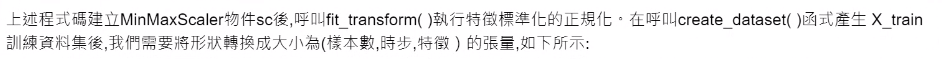

In [79]:
#  (資料集轉為3D張量[樣本數,回看時步,特徵])
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
# print(X_train[0])

(1198, 60, 1)


### 定義LSTM模型

In [80]:
model = Sequential()
model.add(LSTM(50, return_sequences=True,
               input_shape=(X_train.shape[1],1)))  # 第一層輸入層需要定義input_shape
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))   # 輸出前每個input只輸出一個output
model.add(Dropout(0.2))
model.add(Dense(1))   # 全連接層一個節點，因為只要一個結果(答案)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

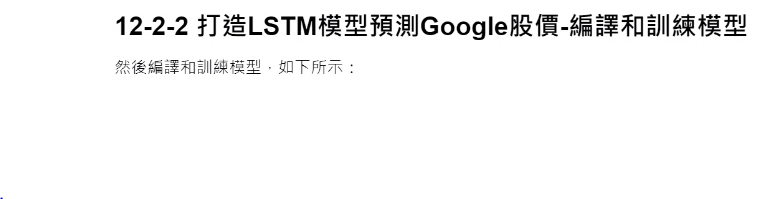
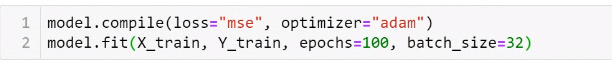

In [81]:
model.compile(loss="mse", optimizer="adam")  
# 分類loss: (categorical|binary)_crossentropy ; 預測loss: mse()  
model.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0399
Epoch 2/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0067
Epoch 3/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0057
Epoch 4/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0055
Epoch 5/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0046
Epoch 6/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0048
Epoch 7/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0044
Epoch 8/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0045
Epoch 9/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0039
Epoch 10/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0046
Epoch 11/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0038
Epoch 12/100
1198/1198 [==============================] - 3s 3ms/step - lo

### 處理測試資料
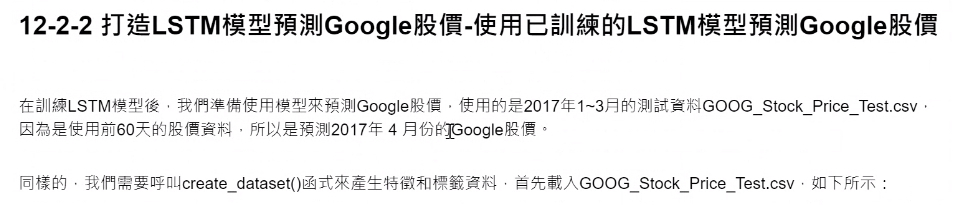
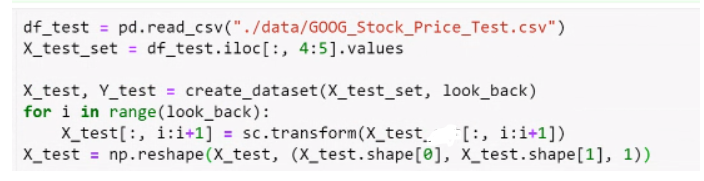

In [83]:
df_test = pd.read_csv("./GOOG/GOOG_Stock_Price_Test.csv",
                     index_col="Date",parse_dates=True)
X_test_set = df_test.iloc[:,4:5].values

X_test, Y_test = create_dataset(X_test_set,look_back)

# 測試集一樣需要正規化，sc是一維，X_test需要每次處理一遍
for i in range(look_back):
    X_test[:, i:i+1] = sc.transform(X_test[:, i:i+1])
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

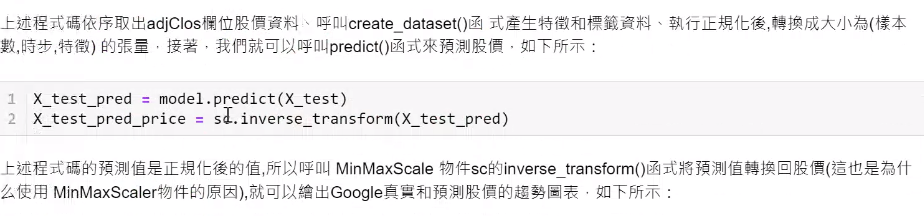

In [84]:
X_test_predict = model.predict(X_test)
X_test_pred_price = sc.inverse_transform(X_test_predict)

In [85]:
print(X_test_pred_price[:5])
print(Y_test[:5])

[[814.40894]
 [819.6151 ]
 [822.3707 ]
 [824.35535]
 [824.53876]]
[831.5      829.559998 838.549988 834.570007 831.409973]


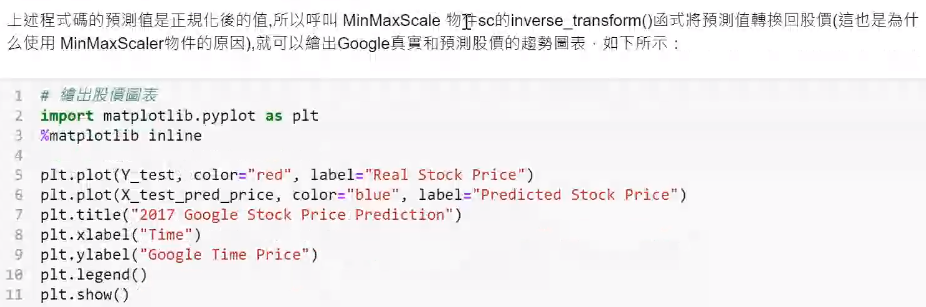
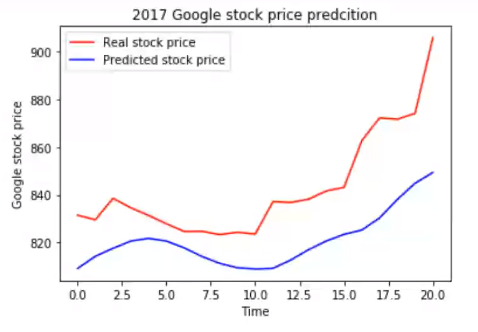

### 畫成圖表 

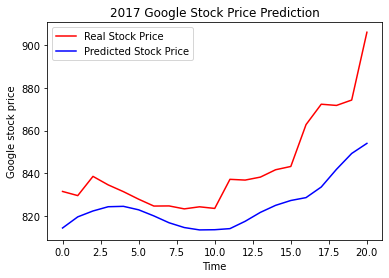

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(Y_test, color="red", label="Real Stock Price")
plt.plot(X_test_pred_price, color="blue", label="Predicted Stock Price")
plt.title("2017 Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google stock price")
plt.legend()
plt.show()

___
# 作業
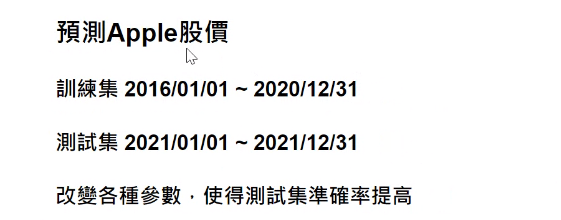


* 取得Apple股價資料
https://finance.yahoo.com/quote/AAPL?p=AAPL&.tsrc=fin-srch


設定取得之訓練集名稱為 AAPL_Stock_Price_Train.csv，測試集名稱為 AAPL_Stock_Price_Test.csv。以收盤價(Adj Close 欄位)為預測的目標。

In [1]:
import numpy as np
import pandas as pd

# 載入股價資料訓練集
df_train = pd.read_csv("./GOOG/AAPL_Stock_Price_Train.csv",header=0,
                      index_col="Date",parse_dates=True)  
X_train_set = df_train.iloc[:,4:5].values  # Adj Close 欄位
print(X_train_set[:10])
X_train_len = len(X_train_set)
print(X_train_len)

def create_dataset(ds, look_back=1):
    X_data, Y_data = [], []  # X: Adj Close for look back; Y: Adj Close label
    for i in range(len(ds)-look_back):  # 設定可以回看的資料範圍(資料集長度-回看的天數)
        X_data.append(ds[i:(i+look_back), 0])
        Y_data.append(ds[i+look_back, 0])
        
    return np.array(X_data), np.array(Y_data)

look_back = 60
X_train, Y_train = create_dataset(X_train_set, look_back=look_back)
print("回看天數：",look_back)
print(X_train.shape)
print(Y_train.shape)
# print(X_train[0])
# print(Y_train[0])  

[[24.220577]
 [23.613628]
 [23.151514]
 [22.174414]
 [22.29166 ]
 [22.65262 ]
 [22.981384]
 [22.390526]
 [22.880226]
 [22.330753]]
1258
回看天數： 60
(1198, 60)
(1198,)


### 建立LSTM模型

製造模型訓練集，設定每個樣本標籤(特徵)為單日收盤價，並設定樣本取該日前60個交易日(時步)內之收盤價。\
訓練資料累計5年的收盤價資料共1258筆。\
以此方式建立訓練集，樣本數量為1258-60=1198筆。

In [2]:
# 引用正規化套件，將特徵標準化
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

np.random.seed(10)

# 載入訓練資料
df_train = pd.read_csv("./GOOG/AAPL_Stock_Price_Train.csv",header=0,
                      index_col="Date",parse_dates=True)  
X_train_set = df_train.iloc[:,4:5].values  # Adj Close 欄位
X_train_len = len(X_train_set)
print("筆數：", X_train_len)
print(X_train_set[:5])
print(X_train_set[-5:])

# 正規化訓練資料 (特徵標準化步驟)
sc = MinMaxScaler()
X_train_set = sc.fit_transform(X_train_set)
print(X_train_set[:5])
print(X_train_set[-5:])

# 產生訓練集(由前幾天的股價以及今日股價)
def create_dataset(ds, look_back=1):
    X_data, Y_data = [], []  # X: Adj Close for look back; Y: Adj Close label
    for i in range(len(ds)-look_back):  # 設定可以回看的資料範圍(資料集長度-回看的天數)
        X_data.append(ds[i:(i+look_back), 0])
        Y_data.append(ds[i+look_back, 0])
        
    return np.array(X_data), np.array(Y_data)

look_back = 60
X_train, Y_train = create_dataset(X_train_set, look_back=look_back)

#  (資料集轉為3D張量[樣本數,回看時步,特徵])
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
# print(X_train[0])

Using TensorFlow backend.


筆數： 1258
[[24.220577]
 [23.613628]
 [23.151514]
 [22.174414]
 [22.29166 ]]
[[129.991989]
 [130.994522]
 [135.679642]
 [133.873077]
 [132.731598]]
[[0.0280025 ]
 [0.0227095 ]
 [0.01867956]
 [0.01015859]
 [0.01118106]]
[[0.95039987]
 [0.95914262]
 [1.        ]
 [0.98424555]
 [0.97429109]]
(1198, 60, 1)


#### 訓練LSTM模型 

In [3]:
model = Sequential()
model.add(LSTM(50, return_sequences=True,
               input_shape=(X_train.shape[1],1)))  # 第一層輸入層需要定義input_shape
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))   # 輸出前每個input只輸出一個output
model.add(Dropout(0.2))
model.add(Dense(1))   # 全連接層一個節點，因為只要一個結果(答案)
model.summary()

model.compile(loss="mse", optimizer="adam")  
# 分類loss: (categorical|binary)_crossentropy ; 預測loss: mse()  
model.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [4]:
# 測試資料
df_test = pd.read_csv("./GOOG/AAPL_Stock_Price_Test.csv",
                     index_col="Date",parse_dates=True)
X_test_set = df_test.iloc[:,4:5].values

X_test, Y_test = create_dataset(X_test_set,look_back)

# 測試集一樣需要正規化，sc是一維，X_test需要每次處理一遍
for i in range(look_back):
    X_test[:, i:i+1] = sc.transform(X_test[:, i:i+1])
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [5]:
# 使用模型預測
X_test_predict = model.predict(X_test)
X_test_pred_price = sc.inverse_transform(X_test_predict)

In [6]:
# 比較預測值與真實值
print(X_test_pred_price[:5])
print(Y_test[:5])

[[120.73348]
 [120.9428 ]
 [121.4624 ]
 [122.56826]
 [123.84994]]
[121.428291 122.27327  125.156136 125.464302 127.144318]


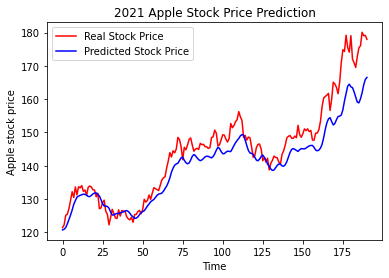

In [8]:
# 畫成圖表
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(Y_test, color="red", label="Real Stock Price")
plt.plot(X_test_pred_price, color="blue", label="Predicted Stock Price")
plt.title("2021 Apple Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Apple stock price")
plt.legend()
plt.show()

由以上圖表可知，使用3層 LSTM 與 Dropout 層，在短期(前50個交易日)的預測結果較接近實際數據，但是長期而言，此模型預測的數據會與真實數據相差愈來愈大，有低估的情況。我們可以提高Dropout層的權重，歸零的比例從0.2調升至0.5，建立以下模型。

In [15]:
# 訓練一個新的LSTM模型
model = Sequential()
model.add(LSTM(50, return_sequences=True,
               input_shape=(X_train.shape[1],1)))  # 第一層輸入層需要定義input_shape
model.add(Dropout(0.5))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50))   # 輸出前每個input只輸出一個output
model.add(Dropout(0.5))
model.add(Dense(1))   # 全連接層一個節點，因為只要一個結果(答案)
model.summary()

model.compile(loss="mse", optimizer="adam")  
# 分類loss: (categorical|binary)_crossentropy ; 預測loss: mse()  
model.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

1198/1198 [==============================] - 3s 3ms/step - loss: 0.0020
Epoch 83/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.0020
Epoch 84/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.0021
Epoch 85/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.0017
Epoch 86/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.0022
Epoch 87/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.0018
Epoch 88/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0020
Epoch 89/100
1198/1198 [==============================] - 3s 3ms/step - loss: 0.0021
Epoch 90/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.0019
Epoch 91/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.0021
Epoch 92/100
1198/1198 [==============================] - 3s 2ms/step - loss: 0.0018
Epoch 93/100
1198/1198 [==============================] - 3s 2ms/step - loss: 

In [16]:
# 使用模型預測
X_test_predict = model.predict(X_test)
X_test_pred_price = sc.inverse_transform(X_test_predict)

In [17]:
# 比較預測值與真實值
print(X_test_pred_price[:5])
print(Y_test[:5])

[[115.71461 ]
 [115.704124]
 [115.87691 ]
 [116.36631 ]
 [117.06071 ]]
[121.428291 122.27327  125.156136 125.464302 127.144318]


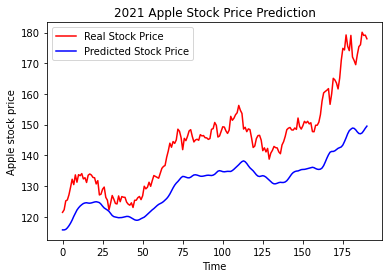

In [18]:
# 畫成圖表
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(Y_test, color="red", label="Real Stock Price")
plt.plot(X_test_pred_price, color="blue", label="Predicted Stock Price")
plt.title("2021 Apple Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Apple stock price")
plt.legend()
plt.show()

由以上圖表可知，將模型的Dropout層歸零權重提高，使用3層 LSTM 與 Dropout 層，此模型預測的數據與真實數據相比，會更加地低估。\
以下修改模型的Dropout層參數，從0.2降至0.1，降低歸零權重比例，重新建立一個LSTM模型。

In [24]:
# 訓練一個新的LSTM模型
model = Sequential()
model.add(LSTM(50, return_sequences=True,
               input_shape=(X_train.shape[1],1)))  # 第一層輸入層需要定義input_shape
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50))   # 輸出前每個input只輸出一個output
model.add(Dropout(0.1))
model.add(Dense(1))   # 全連接層一個節點，因為只要一個結果(答案)
model.summary()

model.compile(loss="mse", optimizer="adam")  
# 分類loss: (categorical|binary)_crossentropy ; 預測loss: mse()  
model.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [25]:
# 使用模型預測
X_test_predict = model.predict(X_test)
X_test_pred_price = sc.inverse_transform(X_test_predict)

In [26]:
# 比較預測值與真實值
print(X_test_pred_price[:5])
print(Y_test[:5])

[[119.48354 ]
 [119.8409  ]
 [120.59666 ]
 [122.14968 ]
 [123.621544]]
[121.428291 122.27327  125.156136 125.464302 127.144318]


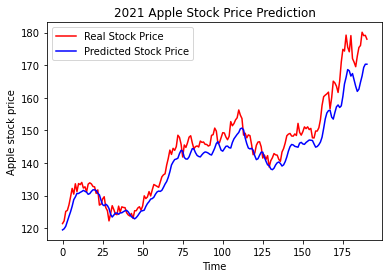

In [27]:
# 畫成圖表
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(Y_test, color="red", label="Real Stock Price")
plt.plot(X_test_pred_price, color="blue", label="Predicted Stock Price")
plt.title("2021 Apple Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Apple stock price")
plt.legend()
plt.show()

由以上圖表可知，將模型的Dropout層歸零權重降低，使用3層 LSTM 與 Dropout 層，仍有低估的情形，不過預測的數據與先前的模型相比，較為接近真實數據。

因此可統整以上的模型，本模型降低了 Dropout 的權重比例，消去了可能低估的情況，而提高了準確率。